# Critical Introduction to Natural Language Processing

Using only the raw text, we'll derive and explore the semantic properties of its words.

## Imports

Python code in one module gains access to the code in another module by the process of importing it. The import statement is the most common way of invoking the import machinery, but it is not the only way.

In [1]:
from __future__ import absolute_import, division, print_function

First we import common system-tools etc. here that are not directly connected to NLP


In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import sklearn.manifold
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

D:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


You will probably run into an "ModuleNorFoundError" here. THis means that the needed module is not installed on your system.
You can do that in the anaconda command prompt:
for example: <b>"conda install -c anaconda nltk"</b> or <b>"conda install -c anaconda gensim"</b> and <b>"conda install -c conda-forge glob2"</b> <br> for detailed information refer to https://docs.anaconda.com/anaconda/user-guide/tasks/install-packages/ <br>


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fmx\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fmx\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("txtdata\*.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['txtdata\\kjvdat.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'txtdata\kjvdat.txt'...
Corpus is now 4521345 characters long



**Build your vocabulary (word tokenization)**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

Given a character sequence and a defined document unit, tokenization is the task of chopping it up into pieces, called tokens , perhaps at the same time throwing away certain characters, such as punctuation.

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

And the fourth river is Euphrates.~
Gen|2|15| And the LORD God took the man, and put him into the garden of Eden to dress it and to keep it.~
Gen|2|16| And the LORD God commanded the man, saying, Of every tree of the garden thou mayest freely eat:~
Gen|2|17| But of the tree of the knowledge of good and evil, thou shalt not eat of it: for in the day that thou eatest thereof thou shalt surely die.~
Gen|2|18| And the LORD God said, It is not good that the man should be alone; I will make him an help meet for him.~
Gen|2|19| And out of the ground the LORD God formed every beast of the field, and every fowl of the air; and brought them unto Adam to see what he would call them: and whatsoever Adam called every living creature, that was the name thereof.~
Gen|2|20| And Adam gave names to all cattle, and to the fowl of the air, and to every beast of the field; but for Adam there was not found an help meet for him.~
Gen|2|21| And the LORD God caused a deep sleep to fall upon Adam, and he slept:

In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 822,543 tokens


## Train Word2Vec

Word2vec is a method of computing vector representations of words introduced by a team of researchers at Google led by Tomas Mikolov. Google hosts an open-source version of Word2vec released under an Apache 2.0 license. In 2014, Mikolov left Google for Facebook, and in May 2015, Google was granted a patent for the method, which does not abrogate the Apache license under which it has been released. <br>

<b>Foreign Languages</b> <br>

While words in all languages may be converted into vectors with Word2vec, and those vectors learned with deep-learning frameworks, NLP preprocessing can be very language specific, and requires tools beyond our libraries. The Stanford Natural Language Processing Group has a number of Java-based tools for tokenization, part-of-speech tagging and named-entity recognition for languages such as Mandarin Chinese, Arabic, French, German and Spanish. For Japanese, NLP tools like Kuromoji are useful. Other foreign-language resources, including text corpora, are available here.
http://www-nlp.stanford.edu/links/statnlp.html

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 200
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-5

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
word2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
word2vec.build_vocab(sentences)

2019-11-12 11:53:27,056 : INFO : collecting all words and their counts
2019-11-12 11:53:27,056 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-11-12 11:53:27,201 : INFO : collected 13597 word types from a corpus of 822543 raw words and 3987 sentences
2019-11-12 11:53:27,201 : INFO : Loading a fresh vocabulary
2019-11-12 11:53:27,223 : INFO : min_count=3 retains 7341 unique words (53% of original 13597, drops 6256)
2019-11-12 11:53:27,224 : INFO : min_count=3 leaves 814409 word corpus (99% of original 822543, drops 8134)
2019-11-12 11:53:27,245 : INFO : deleting the raw counts dictionary of 13597 items
2019-11-12 11:53:27,245 : INFO : sample=1e-05 downsamples 2339 most-common words
2019-11-12 11:53:27,246 : INFO : downsampling leaves estimated 137651 word corpus (16.9% of prior 814409)
2019-11-12 11:53:27,262 : INFO : estimated required memory for 7341 words and 200 dimensions: 15416100 bytes
2019-11-12 11:53:27,263 : INFO : resetting layer weights


In [19]:
print("Word2Vec vocabulary length:", len(word2vec.wv.vocab))

Word2Vec vocabulary length: 7341


**Start training, this might take a minute or two...**

In [20]:
word2vec.train(sentences, total_words=token_count, epochs = 10 )

2019-11-12 11:53:28,428 : INFO : training model with 8 workers on 7341 vocabulary and 200 features, using sg=1 hs=0 sample=1e-05 negative=5 window=7
2019-11-12 11:53:28,694 : INFO : worker thread finished; awaiting finish of 7 more threads
2019-11-12 11:53:28,701 : INFO : worker thread finished; awaiting finish of 6 more threads
2019-11-12 11:53:28,703 : INFO : worker thread finished; awaiting finish of 5 more threads
2019-11-12 11:53:28,705 : INFO : worker thread finished; awaiting finish of 4 more threads
2019-11-12 11:53:28,711 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-12 11:53:28,712 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-12 11:53:28,713 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-12 11:53:28,714 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-12 11:53:28,715 : INFO : EPOCH - 1 : training on 822543 raw words (137257 effective words) took 0.3s, 488472 effect

2019-11-12 11:53:31,448 : INFO : worker thread finished; awaiting finish of 3 more threads
2019-11-12 11:53:31,450 : INFO : worker thread finished; awaiting finish of 2 more threads
2019-11-12 11:53:31,451 : INFO : worker thread finished; awaiting finish of 1 more threads
2019-11-12 11:53:31,452 : INFO : worker thread finished; awaiting finish of 0 more threads
2019-11-12 11:53:31,453 : INFO : EPOCH - 10 : training on 822543 raw words (137756 effective words) took 0.4s, 392181 effective words/s
2019-11-12 11:53:31,454 : INFO : training on a 8225430 raw words (1375493 effective words) took 3.0s, 454753 effective words/s


(1375493, 8225430)

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
word2vec.save(os.path.join("trained", "word2vec.w2v"))

2019-11-12 11:53:31,472 : INFO : saving Word2Vec object under trained\word2vec.w2v, separately None
2019-11-12 11:53:31,473 : INFO : not storing attribute vectors_norm
2019-11-12 11:53:31,474 : INFO : not storing attribute cum_table
D:\Anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2019-11-12 11:53:31,587 : INFO : saved trained\word2vec.w2v


## Explore the trained model.

In [23]:
#Load rhe trained model
word2vec = w2v.Word2Vec.load("word2vec.w2v")

2019-11-12 11:53:31,593 : INFO : loading Word2Vec object from word2vec.w2v
2019-11-12 11:53:31,740 : INFO : loading wv recursively from word2vec.w2v.wv.* with mmap=None
2019-11-12 11:53:31,741 : INFO : setting ignored attribute vectors_norm to None
2019-11-12 11:53:31,741 : INFO : loading vocabulary recursively from word2vec.w2v.vocabulary.* with mmap=None
2019-11-12 11:53:31,742 : INFO : loading trainables recursively from word2vec.w2v.trainables.* with mmap=None
2019-11-12 11:53:31,742 : INFO : setting ignored attribute cum_table to None
2019-11-12 11:53:31,743 : INFO : loaded word2vec.w2v


In [24]:
print(word2vec.wv.most_similar('state', topn=5))

2019-11-12 11:53:31,765 : INFO : precomputing L2-norms of word weight vectors


[('example', 0.9979538917541504), ('wanting', 0.9978142976760864), ('hardness', 0.9975428581237793), ('lasciviousness', 0.9973113536834717), ('reputation', 0.9972676038742065)]


### Compress the word vectors into 2D space and plot them

In [25]:
#tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [26]:
all_word_vectors_matrix = word2vec.wv.vectors

**Train t-SNE, this could take a minute or two...**

In [27]:
all_word_vectors_matrix_2d = tsne_model_en_2d.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [28]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
            for word in word2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [29]:
points.head(100)

,word,x,y
0,Gen,57.872887,-89.214668
1,In,42.371750,-62.451313
2,the,39.796867,-64.563087
3,beginning,-122.059647,-26.817778
4,God,-84.673195,-61.245708
5,created,-146.796524,2.037196
6,heaven,-111.169640,40.361950
7,and,26.048632,-27.700876
8,earth,-118.009987,40.952038
9,And,88.380241,8.215165


In [30]:
sns.set_context("poster")

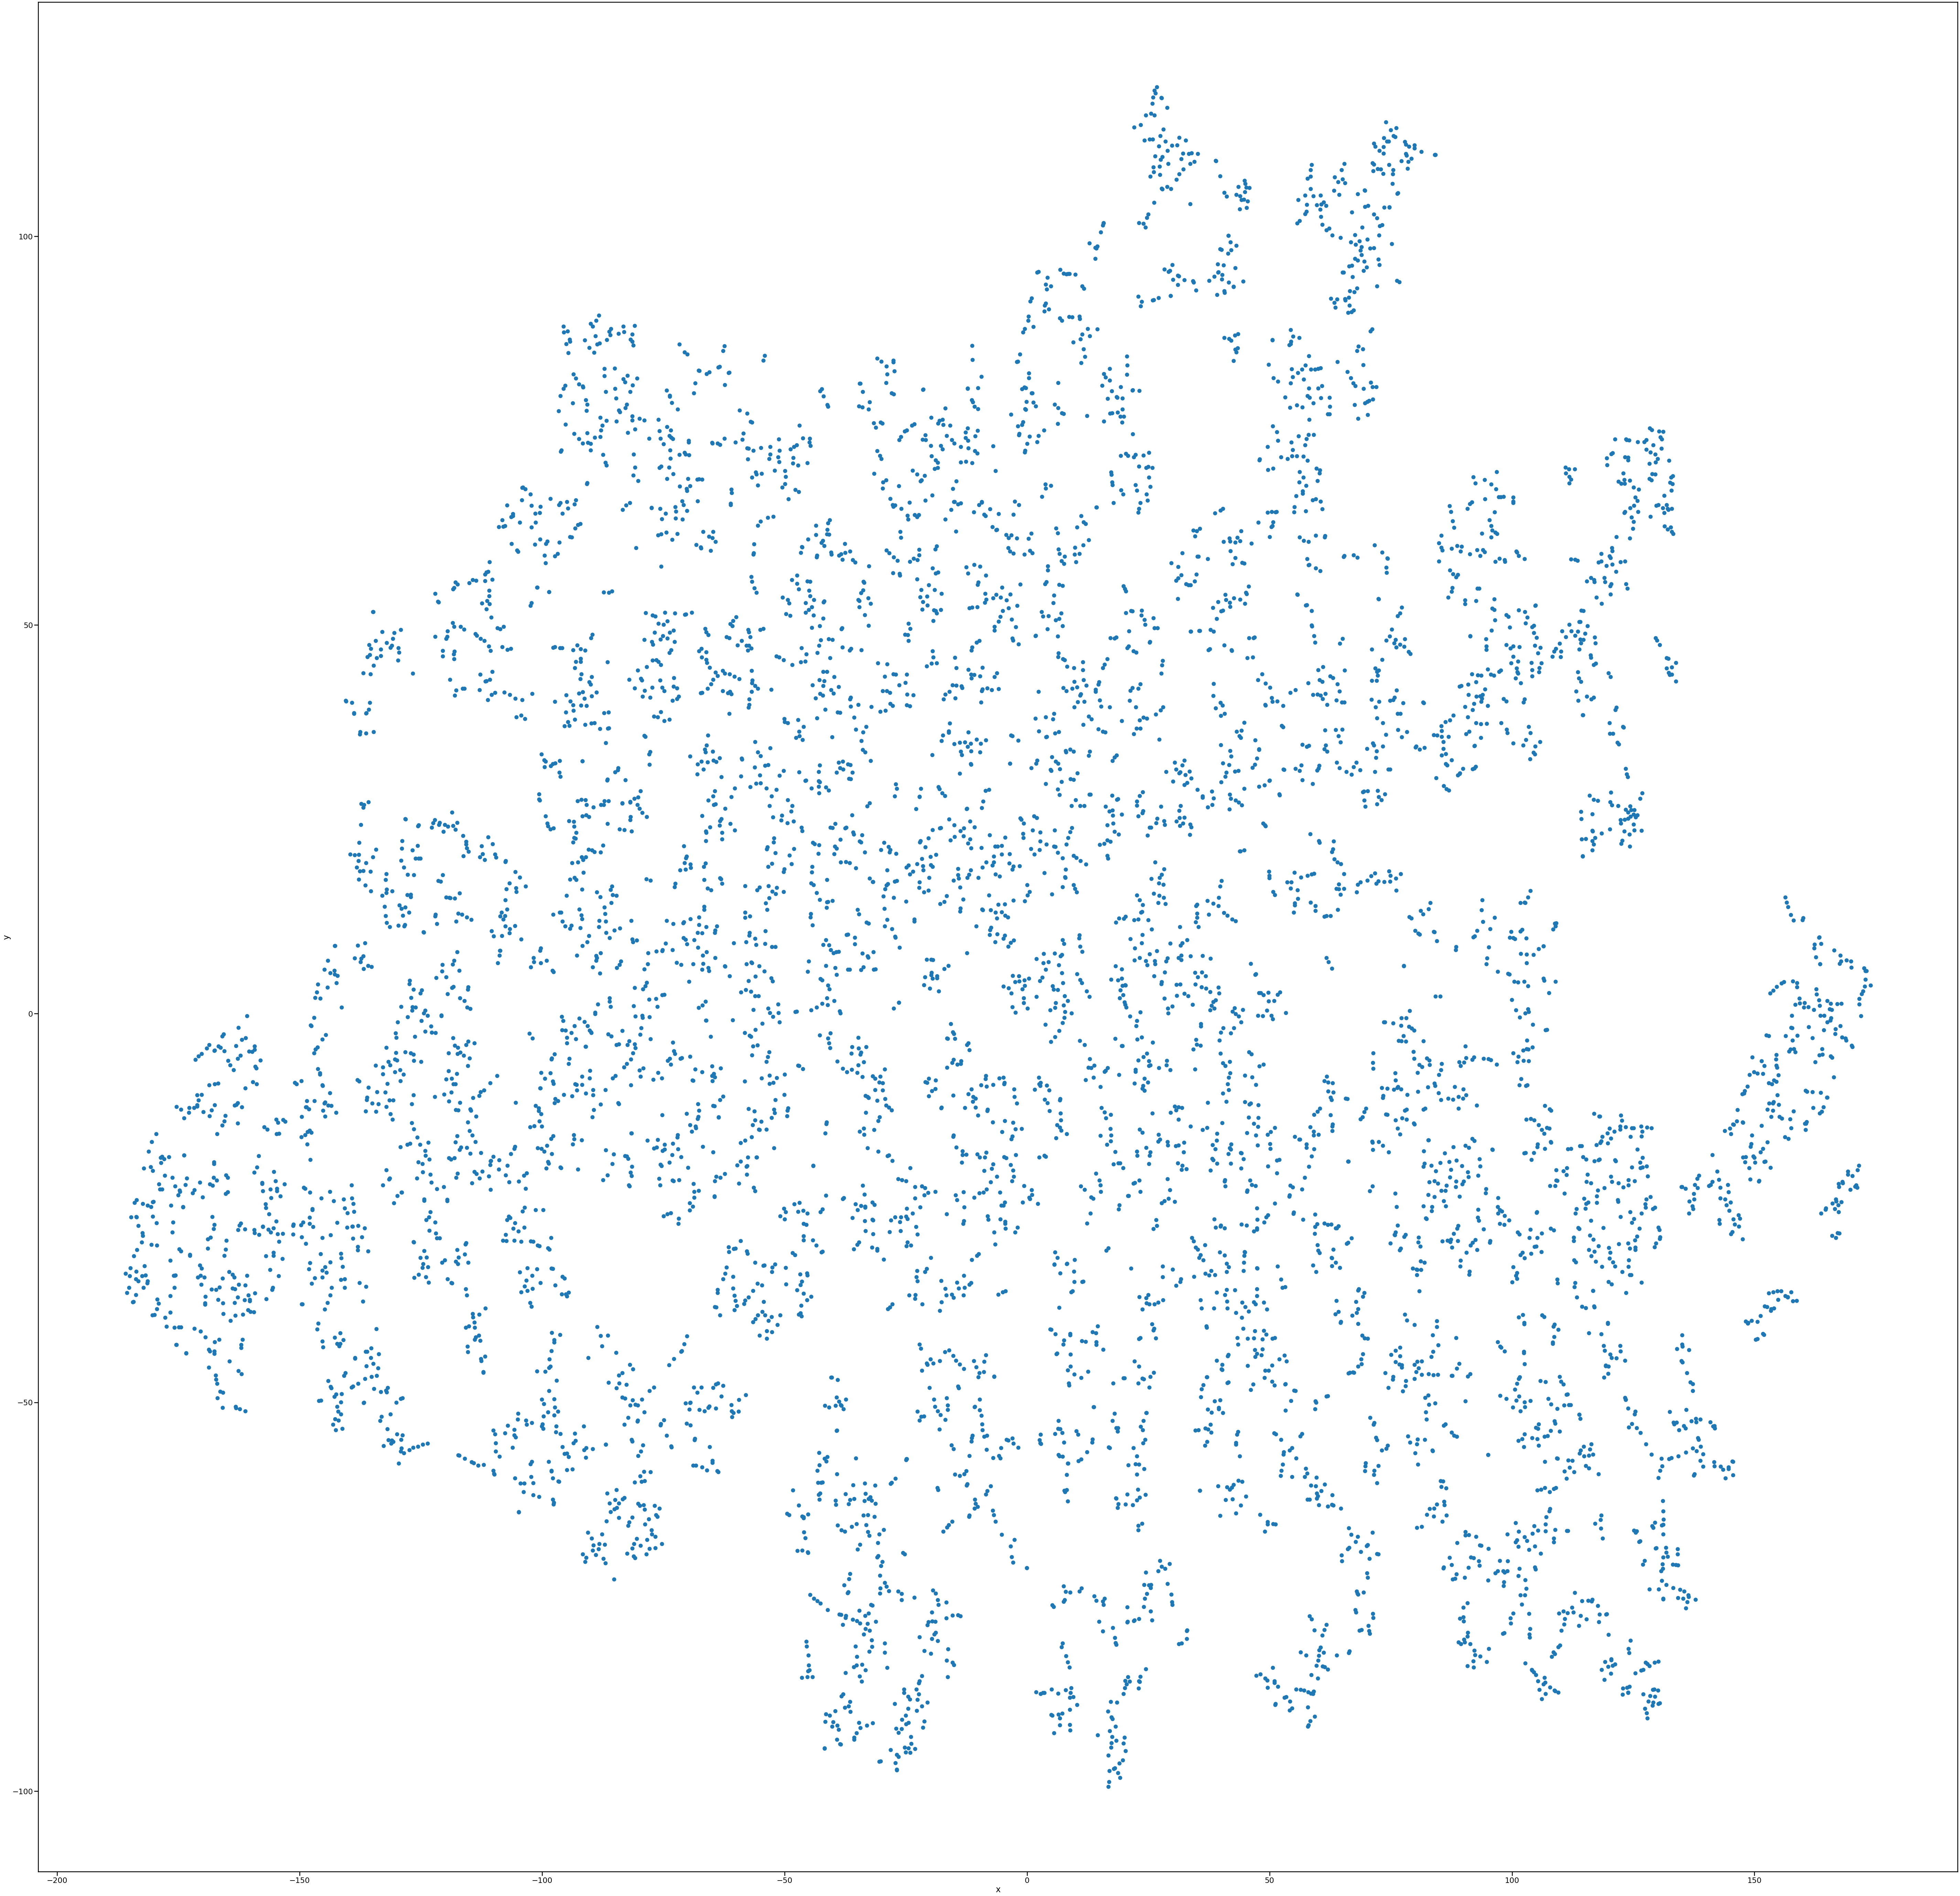

In [31]:
points.plot.scatter("x", "y", s=100, figsize=(100, 100))

**Zoom in to some interesting places**

In [32]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

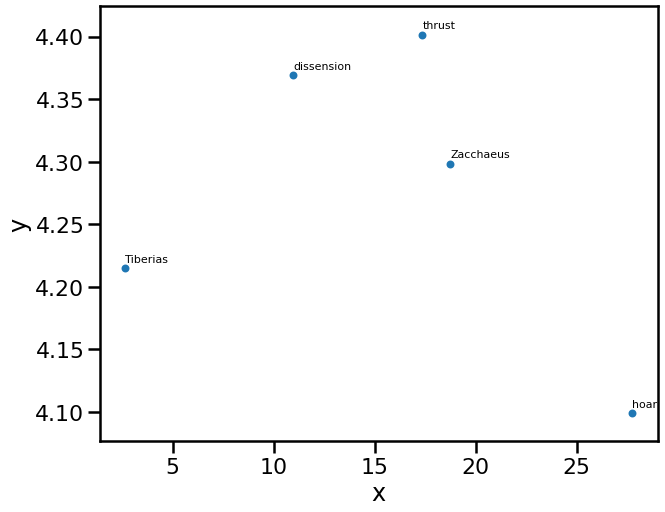

In [33]:
plot_region(x_bounds=(0, 100), y_bounds=(4, 4.5))

### Explore semantic similarities 

https://radimrehurek.com/gensim/models/word2vec.html
    

**Words closest to the given words**

In [34]:
word2vec.wv.most_similar("power")

[('Jde', 0.9941583275794983),
 ('understand', 0.993732213973999),
 ('ignorant', 0.992131769657135),
 ('tribulation', 0.9920140504837036),
 ('elect', 0.9911738634109497),
 ('Gentiles', 0.9910302758216858),
 ('gain', 0.9909514784812927),
 ('revealed', 0.9905986785888672),
 ('saved', 0.9905390739440918),
 ('exhort', 0.9904577136039734)]

In [35]:
word2vec.wv.most_similar("money")

[('bought', 0.9903262257575989),
 ('Levite', 0.9744759798049927),
 ('yearly', 0.9684622287750244),
 ('hired', 0.9681915640830994),
 ('Build', 0.9624722599983215),
 ('selfsame', 0.9621840715408325),
 ('sheep', 0.9598063230514526),
 ('offices', 0.9591748714447021),
 ('priesthood', 0.9587582945823669),
 ('Araunah', 0.9578331708908081)]

In [36]:
word2vec.wv.most_similar("women")

[('saluted', 0.9937931895256042),
 ('hanged', 0.9888575077056885),
 ('band', 0.9885234832763672),
 ('ministered', 0.9868999123573303),
 ('Jezreelitess', 0.9868006706237793),
 ('Joanna', 0.9862409234046936),
 ('Shuah', 0.9857338666915894),
 ('soldiers', 0.9857027530670166),
 ('Naioth', 0.9847684502601624),
 ('grew', 0.9844892024993896)]

**Linear relationships between word pairs**

In [37]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = word2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [38]:
nearest_similarity_cosmul("man", "women", "god")
nearest_similarity_cosmul("god", "men", "state")
nearest_similarity_cosmul("money", "wealth", "city")

man is related to women, as soul is related to god
god is related to men, as tooth is related to state
money is related to wealth, as pitched is related to city


'pitched'

In [39]:
word2vec.wv.most_similar(positive=['god'], negative=['evil'])

[('arches', 0.8902757167816162),
 ('measures', 0.8803756833076477),
 ('chapiter', 0.8780632019042969),
 ('reed', 0.8761708736419678),
 ('palm', 0.8759949803352356),
 ('four', 0.8754749298095703),
 ('beams', 0.8741193413734436),
 ('rows', 0.8728429079055786),
 ('chapiters', 0.8688748478889465),
 ('talents', 0.8682530522346497)]

In [40]:
word2vec.wv.most_similar(positive=['god'], negative=['men'])

[('eateth', 0.7374985814094543),
 ('flesh', 0.725021243095398),
 ('any', 0.7205564975738525),
 ('forgiven', 0.7189397811889648),
 ('if', 0.7023040056228638),
 ('soul', 0.6987016797065735),
 ('vows', 0.6981762051582336),
 ('or', 0.6964105367660522),
 ('fatherless', 0.6916100382804871),
 ('whatsoever', 0.6912089586257935)]

In [41]:
print(word2vec.wv.most_similar_cosmul(positive='king', negative=None, topn=5))

[('Jehoiakim', 0.9789097905158997), ('Nebuchadnezzar', 0.9788773655891418), ('Zedekiah', 0.9777895212173462), ('Ahab', 0.9760644435882568), ('Hezekiah', 0.9757407307624817)]


Text Summarization
This module provides functions for summarizing texts. Summarizing is based on ranks of text sentences using a variation of the TextRank algorithm.
Federico Barrios, Federico L´opez, Luis Argerich, Rosita Wachenchauzer (2016). Variations of the Similarity Function of TextRank for Automated Summarization, https://arxiv.org/abs/1602.03606


In [42]:
#from gensim.summarization import summarize, keywords
#from pprint import pprint

# Summarize the paragraph
#pprint(summarize(corpus_raw, word_count=20))
#> ('the PLA Rocket Force national defense science and technology experts panel, '
#>  'according to a report published by the')

# Important keywords from the paragraph
#print(keywords(text))

In [43]:
# Which word from the given list doesn't go with the others?
print(word2vec.wv.doesnt_match(['god', 'death', 'Ahab', 'Jesus', 'root']))  

Ahab


D:\Anaconda3\lib\site-packages\gensim\models\keyedvectors.py:730: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [44]:
# Compute cosine distance between two words.
print(word2vec.wv.distance('god', 'sun'))
#> 0.22957539558410645

0.11078053713647817


### Get the probability distribution of the center word given context words.

Parameters

        context_words_list (list of str) – List of context words.

        topn (int, optional) – Return topn words and their probabilities.



In [45]:
output_sentence = "A faithful man and god "
wordlist = str.split(output_sentence)
print(word2vec.predict_output_word(context_words_list=wordlist, topn=10))

[('bond', 0.00030567197), ('becometh', 0.00029199236), ('mystery', 0.00029006682), ('conversation', 0.00028215762), ('covetousness', 0.00028131355), ('parents', 0.00028112618), ('thereby', 0.00027894045), ('Jde', 0.00027747927), ('rejoiceth', 0.00027691197), ('froward', 0.0002762233)]


In [46]:
# Get the words closer to w1 than w2
print(word2vec.wv.words_closer_than(w1='king', w2='god'))

['the', 'and', 'of', 'to', 'And', 'in', 'unto', 'they', 'them', 'all', 'was', 'which', 'said', 'out', 'Israel', 'when', 'this', 'up', 'people', 'son', 'came', 'had', 'house', 'into', 'children', 's', 'before', 'Ch', 'day', 'against', 'men', 'Kg', 'at', 'Sa', 'hand', 'went', 'saying', 'Then', 'Jer', 'even', 'go', 'after', 'David', 'over', 'these', 'did', 'name', 'great', 'away', 'city', 'days', 'brought', 'father', 'pass', 'Judah', 'Jerusalem', 'according', 'took', 'behold', 'whom', 'sent', 'set', 'Jos', 'Now', 'heard', 'again', 'called', 'So', 'Jdg', 'Egypt', 'Behold', 'spake', 'done', 'brethren', 'saw', 'fathers', 'years', 'servant', 'together', 'servants', 'gave', 'cities', 'Thus', 'those', 'commanded', 'Dan', 'sword', 'Saul', 'themselves', 'Neh', 'found', 'priests', 'old', 'Jacob', 'year', 'until', 'left', 'kingdom', 'stood', 'taken', 'In', 'sight', 'where', 'kings', 'wilderness', 'Solomon', 'Babylon', 'delivered', 'turned', 'mighty', 'chief', 'told', 'Ezr', 'laid', 'written', 'rest

## Find a word in the plot

In [47]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[word2vec.wv.vocab[word].index])
            for word in word2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

We search for a certain "centerword" in our Dataframe and add '(?:\s|$)' as empty space behind the word, otherwise we will also get matches IN an word as return.  

In [84]:
centerword = "horse"
df = points
df[df['word'].str.match(centerword + '(?:\s|$)')]
value_x = df.loc[df['word'].str.match(centerword + '(?:\s|$)'), 'x'].values[0]
value_y = df.loc[df['word'].str.match(centerword + '(?:\s|$)'), 'y'].values[0]
print(value_x, value_y)

64.20894622802734 35.71609115600586


The values are used to built a plot with a certain width around this word. 

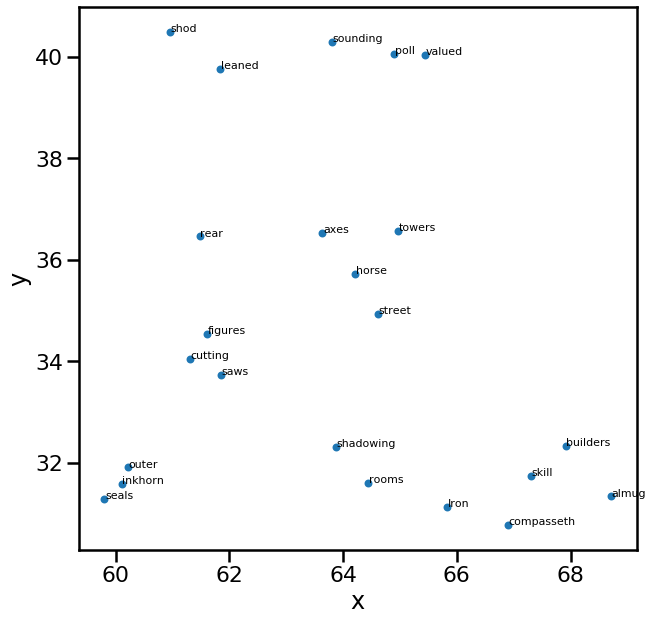

In [85]:
#value_x = -36.29
#value_y = -89.17
width = 10

def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 10))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.008, point.y + 0.008, point.word, fontsize=11)

plot_region(x_bounds=(value_x-width/2, value_x+width/2), y_bounds=(value_y-width/2, value_y+width/2))

## Word Clusters

In [50]:
keys = ['God', 'King', 'Heaven', 'Jesus', 'Jerusalem', 'women', 'devil', 'election']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in word2vec.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(word2vec[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # Remove the CWD from sys.path while we load stuff.


In [51]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

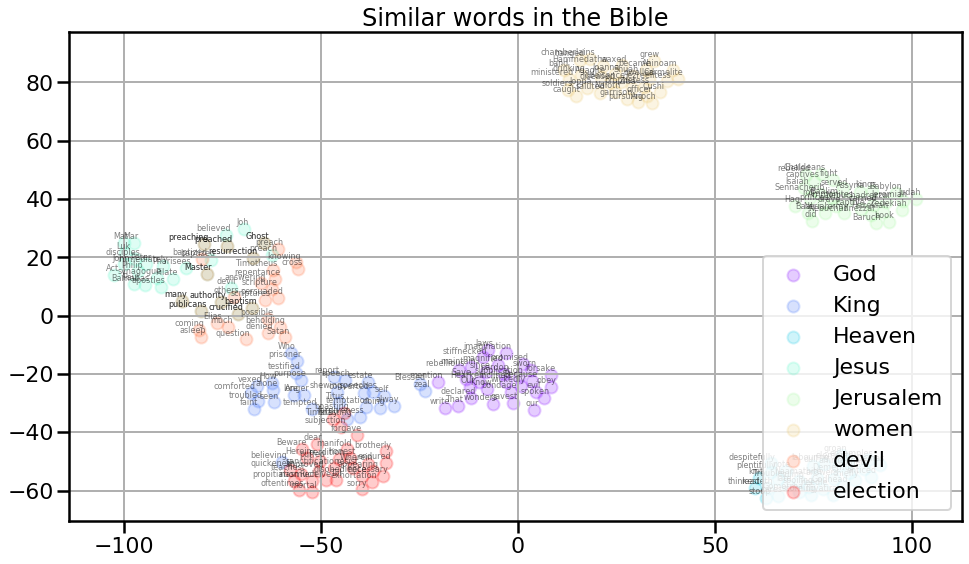

In [86]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words in the Bible', keys, embeddings_en_2d, word_clusters, 0.2,
                        'similar_words.png')

In [53]:
cluster_table = pd.DataFrame(word_clusters, keys)
cluster_table

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
God,supplication,bondage,Know,wickedly,pardon,promised,our,write,Save,inclined,...,imagination,rebellious,mention,magnified,laws,stiffnecked,Our,evil,maintain,Hearken
King,Who,Are,How,seen,purpose,alone,prisoner,converted,troubled,self,...,longer,believing,report,faint,vexed,Blessed,doing,boasting,alway,forgiveness
Heaven,readeth,late,Trouble,ensamples,thinkest,elements,enticed,groan,Naamathite,ruling,...,Godhead,despitefully,affirm,edifieth,scorning,note,needle,dull,Thyatira,cares
Jesus,Joh,Luk,John,Pharisees,disciples,baptized,believed,Act,Pilate,Ghost,...,apostles,publicans,Barnabas,many,baptism,crucified,authority,synagogue,immediately,devil
Jerusalem,Assyria,Babylon,kings,Hezekiah,Jeremiah,served,Nebuchadrezzar,Chaldeans,Sennacherib,carried,...,Neriah,captives,Baruch,Hag,captive,Baal,army,Isaiah,rebelled,drave
women,saluted,hanged,band,ministered,Jezreelitess,Joanna,Shuah,soldiers,Naioth,grew,...,pursuing,prophetess,Carmelite,diseased,obeisance,chamberlains,dwelled,Joppa,officer,waxed
devil,authority,others,possible,repentance,publicans,answering,Master,crucified,scripture,beholding,...,resurrection,many,cross,asleep,question,Elias,preach,preached,Ghost,Satan
election,propitiation,subjection,teachest,honest,sanctification,puffed,perdition,dear,resist,approved,...,exhortation,Receive,disobedience,Till,oftentimes,manifold,necessary,sorry,mortal,Beware


D:\Anaconda3\lib\site-packages\matplotlib\collections.py:857: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


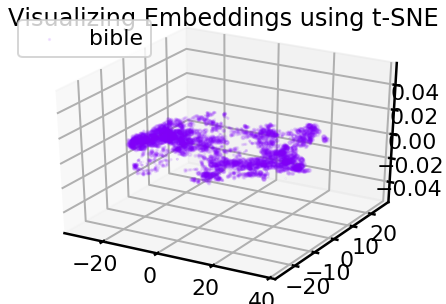

In [90]:
tsne_wp_3d = TSNE(perplexity=10, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(all_word_vectors_matrix)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeddings[:, 0], embeddings[:, 1], embeddings[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=2)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'bible', embeddings_wp_3d, a=0.1)